**This code is base on [2.5d segmentaion baseline [inference]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-inference)**
If you think my code is useful,please upvote it ^w^.
* Version2:
1. *     updata normalization method
2. *     image_size = 512
3. *     useing 3d TTA
4. *     se_resnext50_32x4d

* This version is not correspond with [2.5d segmentaion baseline [training]](https://www.kaggle.com/code/yoyobar/2-5d-cutting-model-baseline-training) version5


# Import

In [1]:
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast
import cv2
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from dotenv import load_dotenv


Looking in links: /kaggle/input/pip-download-for-segmentation-models-pytorch
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/segmentation_models_pytorch-0.3.3-py3-none-any.whl
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/pretrainedmodels-0.7.4.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... - \ done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/efficientnet_pytorch-0.7.1.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... - done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/timm-0.9.2-py3-none-any.whl (from segmentation-models-pytorch)
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/munch-4.0.0-py2.py3-none-any.whl (from pretrainedmodels==0.7.4->segmentation-models-pytorch)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=c1f5dec7fbe0e37d90b27febc

# config

In [2]:
class CFG:
# ============== model CFG =============
    model_name = 'Unet'
    backbone = 'se_resnext101_32x4d'

    in_chans = 5 # 65
    #============== _ CFG =============
    image_size = 512
    input_size=512
    tile_size = image_size
    stride = tile_size // 2
    drop_egde_pixel=0
    
    target_size = 1
    # ============== fold =============
    valid_id = 1
    batch=128
    th_percentile = 0.0021
    model_path=['/kaggle/input/2-5d-cutting-model-baseline-training/se_resnext101_32x4d_19_loss0.01_score0.86_val_loss0.01_val_score0.89.pt']
    #auc=(real auc-0.7)/3*10

# Model

In [3]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.CFG = CFG
        self.encoder = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
        self.batch=CFG.batch

    def forward_(self, image):
        output = self.encoder(image)
        return output[:,0]
    
    def forward(self,x:tc.Tensor):
        x=x.to(tc.float32)
        x=normalization(x,1) # x 정규화
        #x.shape=(batch,c,h,w)
        if CFG.input_size!=CFG.image_size: # bilinear interpolation으로 이미지 크기 조정
            x=nn.functional.interpolate(x,size=(CFG.input_size,CFG.input_size),mode='bilinear',align_corners=True)
        
        shape=x.shape
        x=[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(4)] # 90도 회전 4개 텐서
        x=tc.cat(x,dim=0) # 4개 텐서 연결
        with autocast():
            with tc.no_grad():
                x=[self.forward_(x[i*self.batch:(i+1)*self.batch]) for i in range(x.shape[0]//self.batch+1)]
                # batch=64,64...48, 예측 수행
                x=tc.cat(x,dim=0)
        x=x.sigmoid()
        x=x.reshape(4,shape[0],*shape[2:])
        x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)] # 원래 방향으로 돌려놓고 평균 계산
        x=tc.stack(x,dim=0).mean(0)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x[None],size=(CFG.image_size,CFG.image_size),mode='bilinear',align_corners=True)[0]
        return x


def build_model(weight=None):
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

# Functions

In [4]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]]) # 시작과 끝에 0 추가
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1 # 같지 않은 위치를 true로 나타내는 배열
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 1'
    return rle

def normalization(x:tc.Tensor,smooth=1e-7)->tc.Tensor:
    """input.shape=(batch,f1,f2,...)"""
    #[batch,f1,f2]->dim[1,2]
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    return (x-mean)/(std+smooth)


class Data_loader(Dataset):
    def __init__(self,path,s="/images/"):
        self.paths=glob(path+f"{s}*.tif")
        self.paths.sort()
        self.bool=s=="/labels/"
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img=tc.from_numpy(img)
        if self.bool:
            img=img.to(tc.bool)
        else:
            img=img.to(tc.uint8)
        return img

def load_data(path,s): # 배치 단위로 읽어오기
    data_loader=Data_loader(path,s) # patch : 데이터 경로, s : 하위 경로
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    return x

class Pipeline_Dataset(Dataset):
    def __init__(self,x,path):
        self.img_paths  = glob(path+"/images/*")
        self.img_paths.sort()
        #assert int(self.img_paths[-1].split("/")[-1][:-4])+1==len(x)#it seem not same
        self.in_chan = CFG.in_chans
        z=tc.zeros(self.in_chan//2,*x.shape[1:],dtype=x.dtype) # 제로 패딩 텐서
        self.x=tc.cat((z,x,z),dim=0)
        
    def __len__(self):
        return self.x.shape[0]-self.in_chan+1
    
    def __getitem__(self, index):
        x  = self.x[index:index+self.in_chan]
        return x,index
    
    def get_mark(self,index):
        id=self.img_paths[index].split("/")[-3:]
        id.pop(1)
        id="_".join(id)
        return id[:-4]
    
    def get_marks(self):
        ids=[]
        for index in range(len(self)):
            ids.append(self.get_mark(index))
        return ids

def add_edge(x:tc.Tensor,edge:int): # 경계선 추가
    #x=(C,H,W)
    #output=(C,H+2*edge,W+2*edge)
    mean_=int(x.to(tc.float32).mean())
    x=tc.cat([x,tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_],dim=1)
    x=tc.cat([x,tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_],dim=2)
    x=tc.cat([tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_,x],dim=1)
    x=tc.cat([tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_,x],dim=2)
    return x

# Build model(s)

In [5]:
model=build_model()
state_dict=(tc.load(CFG.model_path[0],"cpu"))


model_name Unet
backbone se_resnext101_32x4d


In [6]:
keys_to_rename = [key for key in state_dict.keys() if key.startswith('module.')]
for key in keys_to_rename:
    new_key = key.replace('module.encoder', 'encoder')
    state_dict[new_key] = state_dict.pop(key)

In [7]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
model=DataParallel(model)

In [9]:
def get_output(debug=False):
    outputs=[]
    if debug:
        paths=["/kaggle/input/blood-vessel-segmentation/train/kidney_2"]
    else:
        paths=glob("/kaggle/input/blood-vessel-segmentation/test/*")
    outputs=[[],[]]
    for path in paths:
        x=load_data(path,"/images/")
        labels=tc.zeros_like(x,dtype=tc.uint8) # 레이블 마킹 정보 초기화
        mark=Pipeline_Dataset(x,path).get_marks()
        for axis in [0,1,2]:
            debug_count=0
            if axis==0: # 축에 따라 이미지 레이블 처리
                x_=x
                labels_=labels
            elif axis==1:
                x_=x.permute(1,2,0)
                labels_=labels.permute(1,2,0)
            elif axis==2:
                x_=x.permute(2,0,1)
                labels_=labels.permute(2,0,1)
            if x.shape[0]==3 and axis!=0:
                break
            dataset=Pipeline_Dataset(x_,path)
            dataloader=DataLoader(dataset,batch_size=1,shuffle=False,num_workers=2)
            shape=dataset.x.shape[-2:] # 이미지 높이와 너비
            x1_list = np.arange(0, shape[0]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            y1_list = np.arange(0, shape[1]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            for img,index in tqdm(dataloader):
                #img=(1,C,H,W)
                img=img.to("cuda:0") # 이미지 gpu 이동
                img=add_edge(img[0],CFG.tile_size//2)[None] # 이미지 주변에 edge 및 미니배치 차원 추가 -> 이미지 전처리

                mask_pred = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)
                mask_count = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)

                indexs=[]
                chip=[]
                for y1 in y1_list: # 이미지를 타일로 나눠서 처리
                    for x1 in x1_list:
                        x2 = x1 + CFG.tile_size
                        y2 = y1 + CFG.tile_size
                        indexs.append([x1+CFG.drop_egde_pixel,x2-CFG.drop_egde_pixel,
                                       y1+CFG.drop_egde_pixel,y2-CFG.drop_egde_pixel])
                        chip.append(img[...,x1:x2,y1:y2])

                y_preds = model.forward(tc.cat(chip)).to(device=0) # 모델 입력으로 해서 예측 수행

                if CFG.drop_egde_pixel:
                    y_preds=y_preds[...,CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                        CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
                for i,(x1,x2,y1,y2) in enumerate(indexs):
                    mask_pred[...,x1:x2, y1:y2] += y_preds[i] # 이미지 대한 전체 예측 결과 누적
                    mask_count[...,x1:x2, y1:y2] += 1

                mask_pred /= mask_count # 각 픽셀에 대한 평균

                #Rrecover
                mask_pred=mask_pred[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2] # 경계부분 제거 후 최종 예측 결과
                
                labels_[index]+=(mask_pred[0]*255/3).to(tc.uint8).cpu()
                if debug:
                    debug_count+=1
                    plt.subplot(121)
                    plt.imshow(img[0,CFG.in_chans//2].cpu().detach().numpy())
                    plt.subplot(122)
                    plt.imshow(mask_pred[0].cpu().detach().numpy())
                    plt.show()
                    if debug_count>3:
                        break
        outputs[0].append(labels)
        outputs[1].extend(mark)
    return outputs

  0%|          | 0/2217 [00:00<?, ?it/s]

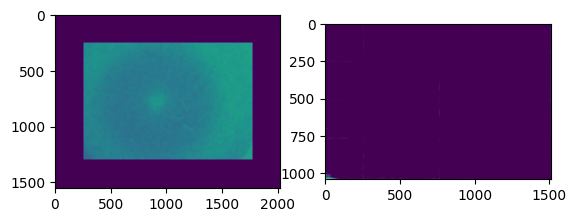

  0%|          | 1/2217 [00:09<5:54:58,  9.61s/it]

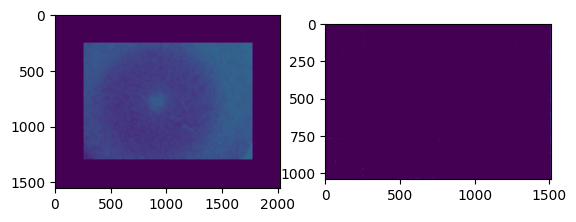

  0%|          | 2/2217 [00:11<3:05:05,  5.01s/it]

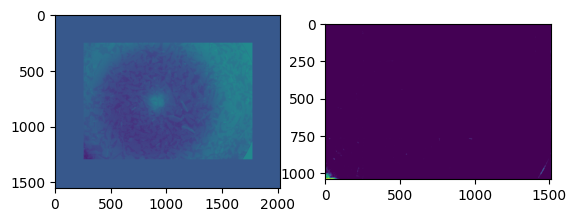

  0%|          | 3/2217 [00:13<2:10:36,  3.54s/it]

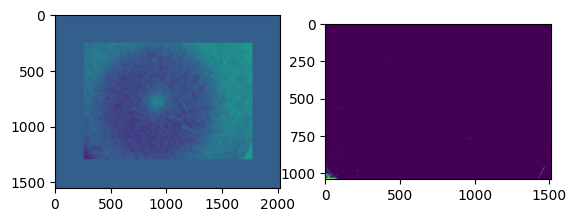

  0%|          | 0/1041 [00:00<?, ?it/s]

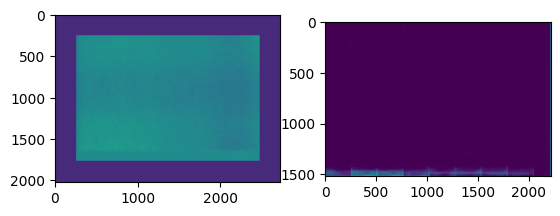

  0%|          | 1/1041 [00:03<1:01:51,  3.57s/it]

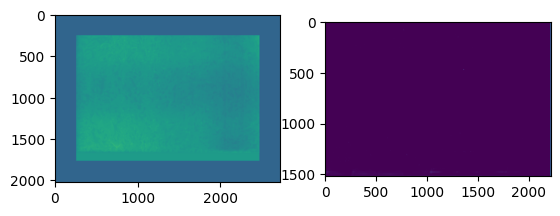

  0%|          | 2/1041 [00:06<56:18,  3.25s/it]  

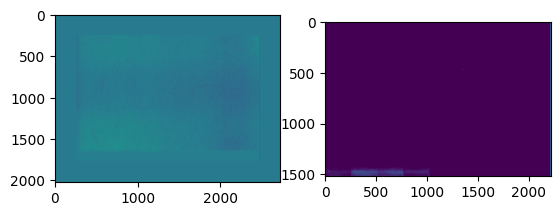

  0%|          | 3/1041 [00:09<54:09,  3.13s/it]

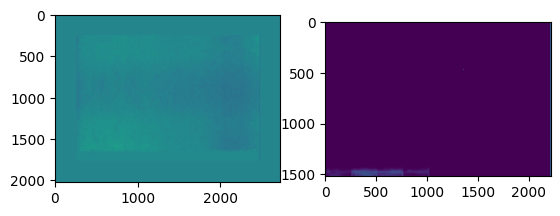

  0%|          | 0/1511 [00:00<?, ?it/s]

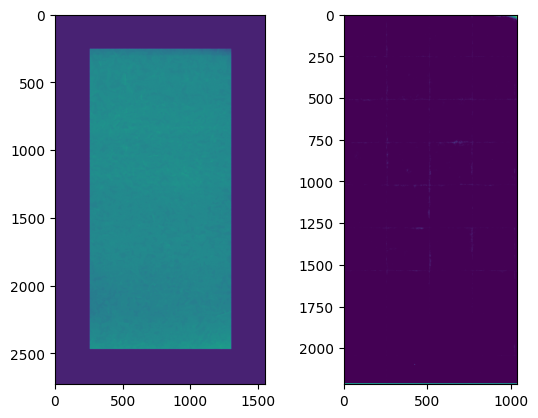

  0%|          | 1/1511 [00:06<2:39:03,  6.32s/it]

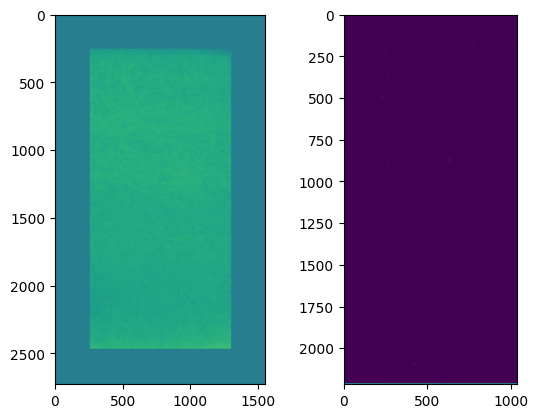

  0%|          | 2/1511 [00:09<1:48:36,  4.32s/it]

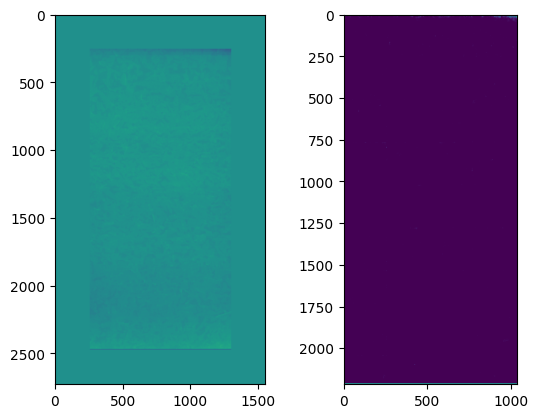

  0%|          | 3/1511 [00:11<1:28:41,  3.53s/it]

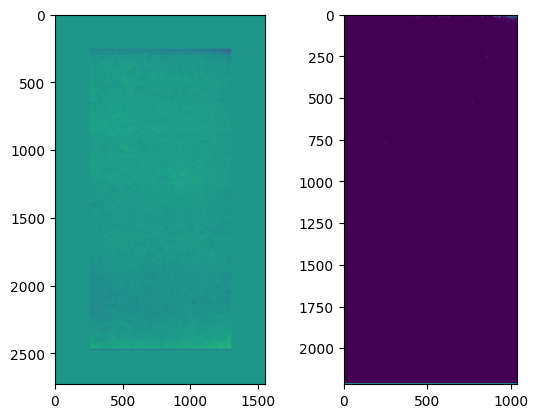

  0%|          | 3/1511 [00:14<2:03:41,  4.92s/it]


0


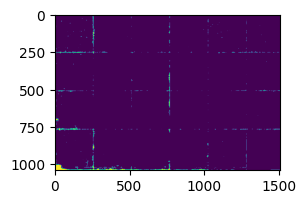

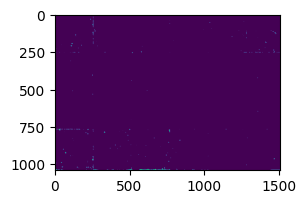

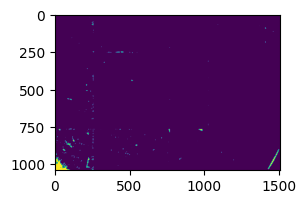

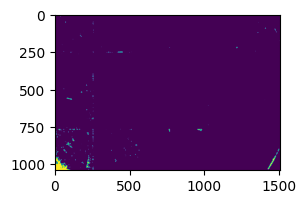

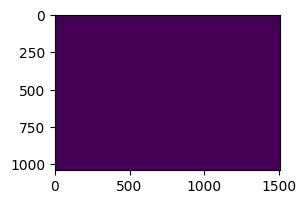

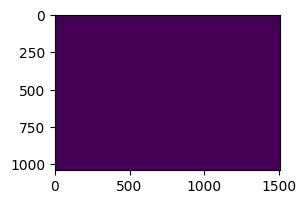

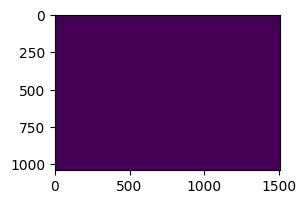

,id,rle
0,kidney_2_0000,1 137 142 55 202 23 226 7 234 31 289 1 294 7 3...
0,kidney_2_0001,1 774 789 10 800 4 832 5 841 4 862 4 869 1 891...
0,kidney_2_0002,1 9 22 2 44 29 79 2 105 6 226 9 256 2 260 1 36...
0,kidney_2_0003,1 7 47 5 55 10 227 10 256 2 260 1 351 1 512 2 ...
0,kidney_2_0004,1 5 256 2 259 1 512 1 768 4 1423 90 1514 2 302...
0,kidney_2_0005,1 3 256 1 512 1 769 3 1424 89 1514 1 2977 10 3...


In [10]:
is_submit=len(glob("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif"))!=3
#is_submit=True
output,ids=get_output(not is_submit)


####################################
TH=[x.flatten().numpy() for x in output]
TH=np.concatenate(TH)
index = -int(len(TH) * CFG.th_percentile)
TH:int = np.partition(TH, index)[index]
print(TH)

####################################
submission_df=[]
debug_count=0
for index in range(len(ids)):
    id=ids[index]
    i=0
    for x in output:
        if index>=len(x):
            index-=len(x)
            i+=1
        else:
            break
    mask_pred=(output[i][index]>TH).numpy()
    ####################################
    if not is_submit:
        plt.subplot(121)
        plt.imshow(mask_pred)
        plt.show()
        debug_count+=1
        if debug_count>6:
            break
        
    rle = rle_encode(mask_pred)
    
    submission_df.append(
        pd.DataFrame(data={
            'id'  : id,
            'rle' : rle,
        },index=[0])
    )

submission_df =pd.concat(submission_df)
submission_df.to_csv('submission.csv', index=False)
submission_df.head(6)

In [11]:
submission_df

,id,rle
0,kidney_2_0000,1 137 142 55 202 23 226 7 234 31 289 1 294 7 3...
0,kidney_2_0001,1 774 789 10 800 4 832 5 841 4 862 4 869 1 891...
0,kidney_2_0002,1 9 22 2 44 29 79 2 105 6 226 9 256 2 260 1 36...
0,kidney_2_0003,1 7 47 5 55 10 227 10 256 2 260 1 351 1 512 2 ...
0,kidney_2_0004,1 5 256 2 259 1 512 1 768 4 1423 90 1514 2 302...
0,kidney_2_0005,1 3 256 1 512 1 769 3 1424 89 1514 1 2977 10 3...
